This is the offline notebook that will pull the information in from csv files and peform the modeling.

In [156]:
import pandas as pd
import numpy as np

nfl_qb_df = pd.read_csv('master_nfl_qb_df_filter.csv')
college_qb_df = pd.read_csv('master_qb_df.csv')
print('NFL df shape:', nfl_qb_df.shape)
print('College df shape:', college_qb_df.shape)

NFL df shape: (174, 129)
College df shape: (1438, 54)


Now that we have the nfl and college qb df's loaded, we need to do a little data processing with the nfl dataframe to remove the non quarterbacks that are still remaining.

In [157]:
nfl_qb_df = nfl_qb_df[nfl_qb_df['qb_record'].notnull()]
print('NFL df shape:', nfl_qb_df.shape)

NFL df shape: (158, 129)


1. Need to get list of Pro-Bowl QB's and add that to the nfl qb dataframe.  
2. Then I will need a subset of qb's that have played at least 5 years, (started at least half their games), and have gone to a probowl.  
3. From there, I can then make a column that says "Success, true/false" and then send that back to the college qb df.

In [158]:
nfl_qb_df['Player']

0        Rodney Peete
2        Charlie Frye
3         Chris Simms
6       Brodie Croyle
7        Chris Weinke
            ...      
168       Nick Foles 
169    Jameis Winston
170         Matt Ryan
171       Elvis Grbac
173     Philip Rivers
Name: Player, Length: 158, dtype: object

In [159]:
# we will read in the original dataset of the NFL QB's to get the list of Pro Bowl Quarterbacks

original_nfl_qb_df = pd.read_excel('NFL_QBS_2000-2015.xlsx', sheet_name='OriginalData')

def probowl(qb_name):
    if '*' in qb_name:
        return True
    else:
        return False

original_nfl_qb_df = original_nfl_qb_df[original_nfl_qb_df['Pos'] != 'wr']
original_nfl_qb_df = original_nfl_qb_df[(original_nfl_qb_df['Pos'] == 'QB') | (original_nfl_qb_df['Pos'] == '/qb') | (original_nfl_qb_df['Pos'].isnull()) | (original_nfl_qb_df['Pos'] == 'qb')]

original_nfl_qb_df['ProBowl'] = original_nfl_qb_df['Player'].apply(probowl)


nfl_pro_bowl_qb_list = original_nfl_qb_df[original_nfl_qb_df['ProBowl'] == True]

nfl_pro_bowl_qb_list = nfl_pro_bowl_qb_list['Player'].to_list()
print(len(nfl_pro_bowl_qb_list))
nfl_pro_bowl_qb_list = [x.replace("+", "") for x in nfl_pro_bowl_qb_list]
nfl_pro_bowl_qb_list = [x.replace("*", "") for x in nfl_pro_bowl_qb_list]
nfl_pro_bowl_qb_list = list(set(nfl_pro_bowl_qb_list))

# now that we have our list, we can create our column in the nfl_qb_df that shows those quarterbacks who have been selected to a pro-bowl
pro_bowl_qb = pd.DataFrame({'name': nfl_pro_bowl_qb_list, 'Boolean': True})
nfl_qb_df['Pro Bowl Selection'] = nfl_qb_df['Player'].isin(pro_bowl_qb['name'])
nfl_qb_df['Pro Bowl Selection']





195


0      False
2      False
3      False
6      False
7      False
       ...  
168     True
169     True
170     True
171     True
173     True
Name: Pro Bowl Selection, Length: 158, dtype: bool

In [160]:
'''# Now we need a column denoting those NFL QB's who have started at least half of their games 
(datframe is already filterd to those qb's that have played at least 5 years).'''

# Successful QB column
# I believe it is safe to assume that if a qb has made the pro-bowl, they have started at least half of their
# games, so we will make the column denote 1 for those that 

nfl_qb_df['Pct_Games_Started'] = nfl_qb_df['games_started']/nfl_qb_df['games']
# nfl_qb_df['Pct_Games_Started']

def start_hurdle(percentage):
    if percentage >= 0.50: 
        return 1 
    else: 
        return 0

nfl_qb_df['Successful_QB'] = nfl_qb_df['games_started'].apply(start_hurdle)


In [161]:
# Now we can carry this list of qb's back to the college dataframe to denote those quarterbacks that were successful.

# master_qb_df.csv has the list of names under the column 'name'
# nfl_qb_df_filter has list of names under the column 'Player'

success_nfl_qb_df = nfl_qb_df[['Player', 'Successful_QB']]
print(success_nfl_qb_df.shape)

final_df = college_qb_df.merge(success_nfl_qb_df, left_on='name', right_on='Player', how='left')
final_df['Successful_QB'] = final_df['Successful_QB'].fillna(0)
final_df['Player'] = final_df['Player'].fillna(final_df['name'])



(158, 2)


In [162]:

# Delete columns containing either 35% or more than 35% NaN Values
perc = 35.0
min_count =  int(((100-perc)/100)*final_df.shape[0] + 1)
final_df = final_df.dropna( axis=1, 
                thresh=min_count)
final_df = final_df.drop(columns=['Unnamed: 0'])
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1438 entries, 0 to 1437
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   adjusted_yards_per_attempt        1365 non-null   float64
 1   completed_passes                  1365 non-null   float64
 2   interceptions_thrown              1365 non-null   float64
 3   name                              1438 non-null   object 
 4   pass_attempts                     1365 non-null   float64
 5   passing_completion                1365 non-null   float64
 6   passing_touchdowns                1365 non-null   float64
 7   passing_yards                     1365 non-null   float64
 8   passing_yards_per_attempt         1365 non-null   float64
 9   player_id                         1438 non-null   object 
 10  plays_from_scrimmage              1381 non-null   float64
 11  points                            987 non-null    float64
 12  positi

Feature: 0, Score: 0.00308
Feature: 1, Score: 0.01727
Feature: 2, Score: 0.01458
Feature: 3, Score: -0.18183
Feature: 4, Score: 0.00012
Feature: 5, Score: 0.01912
Feature: 6, Score: 0.20541
Feature: 7, Score: -0.00288
Feature: 8, Score: 0.21757
Feature: 9, Score: 0.38903
Feature: 10, Score: -0.00403
Feature: 11, Score: -0.26619
Feature: 12, Score: 0.01971
Feature: 13, Score: 0.11971
Feature: 14, Score: -0.00079
Feature: 15, Score: 0.28864
Feature: 16, Score: -0.65050
Feature: 17, Score: -0.12686
Feature: 18, Score: 0.00335


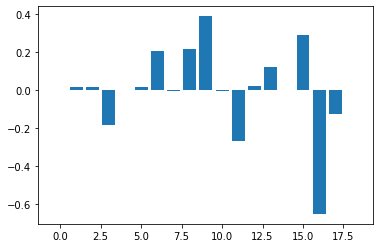

In [178]:
# Ready for feature importance selection.
# Using Linear Regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# need to drop columns that are something other than numbers (name, player_id, position, season, Player)
# final_df = final_df.drop(columns=['name', 'player_id', 'position', 'season', 'team_abbreviation','Player'])
# final_df = final_df.reset_index()

final_df = final_df.fillna(0)
# print(final_df.info())

# Scaling the data
model = LinearRegression()
X = final_df.loc[:,final_df.columns != 'Successful_QB']
y = final_df['Successful_QB']

columns = X.columns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns = columns)
X_std = X_std.drop(columns=['level_0', 'index'])
# print(X_std.head())


model.fit(X_std,y)
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


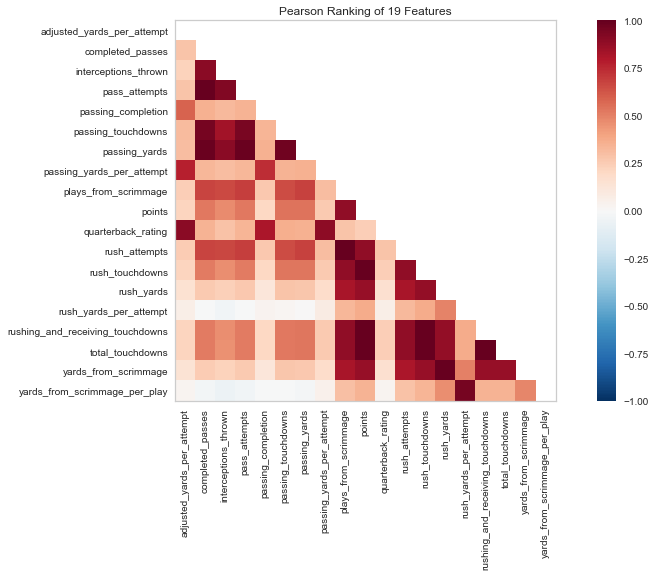

In [182]:
#set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

num_features = ['adjusted_yards_per_attempt', 'completed_passes', 'interceptions_thrown', 'pass_attempts', 
'passing_completion', 'passing_touchdowns', 'passing_yards', 'passing_yards_per_attempt', 'plays_from_scrimmage',
'points', 'quarterback_rating', 'rush_attempts','rush_touchdowns', 'rush_yards', 'rush_yards_per_attempt',
'rushing_and_receiving_touchdowns', 'total_touchdowns', 'yards_from_scrimmage', 'yards_from_scrimmage_per_play']

# extract the numpy arrays from the data frame
x = X[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(x)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof(outpath="pcoords1.png") # Draw/show/poof the data
plt.show()

Based on this information, there are a handful of features that can be eliminated due to their high correlation.  I will need to keep those features that have more orignal data than thsoe that had fill in values of 0.  After determining this, delete those features and re-run the feature importance selections.

Feature: 0, Score: 0.28978
Feature: 1, Score: -0.26030
Feature: 2, Score: 0.27475
Feature: 3, Score: -0.23408
Feature: 4, Score: 0.08686
Feature: 5, Score: 0.40594
Feature: 6, Score: 0.92312
Feature: 7, Score: 0.10291
Feature: 8, Score: -0.26405
Feature: 9, Score: 0.54164
Feature: 10, Score: -0.15799
Feature: 11, Score: -0.07125
Feature: 12, Score: 0.17275
Feature: 13, Score: 0.12419
Feature: 14, Score: 0.21718
Feature: 15, Score: -0.07293
Feature: 16, Score: -0.10689
Feature: 17, Score: -0.37300
Feature: 18, Score: -0.08953


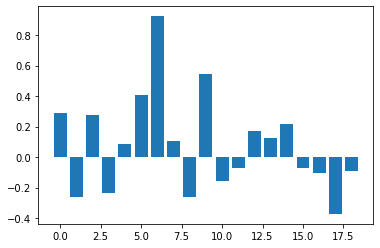

In [179]:
# Ready for feature importance selection.
# Using Logistic Regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# need to drop columns that are something other than numbers (name, player_id, position, season, Player)
# final_df = final_df.drop(columns=['name', 'player_id', 'position', 'season', 'team_abbreviation','Player'])
# final_df = final_df.reset_index()

# final_df = final_df.fillna(0)
# print(final_df.info())
model = LogisticRegression()
# X = final_df.loc[:,final_df.columns != 'Successful_QB']
# y = final_df['Successful_QB']

model.fit(X_std,y)
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.04198
Feature: 1, Score: 0.06168
Feature: 2, Score: 0.06553
Feature: 3, Score: 0.02932
Feature: 4, Score: 0.10991
Feature: 5, Score: 0.17483
Feature: 6, Score: 0.04490
Feature: 7, Score: 0.00360
Feature: 8, Score: 0.04322
Feature: 9, Score: 0.05251
Feature: 10, Score: 0.12300
Feature: 11, Score: 0.03712
Feature: 12, Score: 0.06175
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.03808
Feature: 15, Score: 0.00649
Feature: 16, Score: 0.06312
Feature: 17, Score: 0.01462
Feature: 18, Score: 0.02835


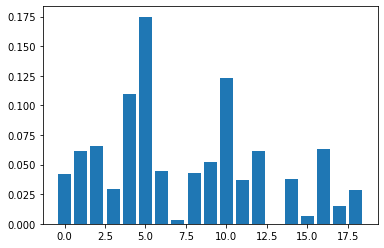

In [180]:
# Ready for feature importance selection.
# Using Logistic Regression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# need to drop columns that are something other than numbers (name, player_id, position, season, Player)
# final_df = final_df.drop(columns=['name', 'player_id', 'position', 'season', 'team_abbreviation','Player'])
# final_df = final_df.reset_index()

# final_df = final_df.fillna(0)
# print(final_df.info())
model = DecisionTreeRegressor()
# X = final_df.loc[:,final_df.columns != 'Successful_QB']
# y = final_df['Successful_QB']

model.fit(X_std,y)
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()